## Imports

In [1]:
# Enable automatic extension autoreloading
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch

import datasets
# Don't show progress datasets bars
datasets.disable_progress_bar()

import sys
sys.path.insert(0, str(Path.cwd().parent.resolve()))
from dataset import get_dataset_qnli, collator
from model import get_model
from reward_model import get_template, get_reward_model, create_reward_fn
from utils import get_tokenizer

['/fsx/home-augustas/elk/elk/promptsource', '/fsx/home-augustas/elk']


## Config

In [3]:
device = torch.device(
    f"cuda:{torch.cuda.current_device()}" if torch.cuda.is_available() else "cpu"
)
device

device(type='cuda', index=0)

In [38]:
tokenizer_name = "lmsys/vicuna-7b-v1.3"

# Large
# reward_model_output_path = "/fsx/home-augustas/logs/UQA-varied-custom_data_qnli_vicuna_v1_20230721_234029_40903"
# 3B
reward_model_output_path = "/fsx/home-augustas/logs/UQA-varied-custom_data_qnli_vicuna_v1_20230721_234034_40904"

## Load things in

In [5]:
# Tokenizer
# tokenizer = get_tokenizer(tokenizer_name)

tokenizer = get_tokenizer("huggyllama/llama-7b")
tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.unk_token

Loading tokenizer huggyllama/llama-7b...


Using pad_token, but it is not set yet.


Loaded tokenizer.



In [6]:
# Dataset for PPO training
train_dataset = get_dataset_qnli(tokenizer, version="v1", margin=8)

# Dataset templates
dataset_template_path = "AugustasM/burns-datasets-VINC"
template = get_template(dataset_template_path)

Loading dataset...



Found cached dataset parquet (/admin/home-augustas/.cache/huggingface/datasets/AugustasM___parquet/AugustasM--qnli-vicuna-ppo-training-v1-e9526ea8884b4bb3/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


Remaining columns: ['prompt', 'best_response', 'input_ids', 'attention_mask']

Total number of examples: 8192

Data preprocessing finished.

Num templates: 1
Is the given text truthful


In [39]:
# Get the reward model
reward_model, reward_model_name = get_reward_model(
    reward_model_output_path, device,
    supervised=True,
)
reward_model_tokenizer = get_tokenizer(reward_model_name)

The current device is cuda:0.

Loading reward model from allenai/unifiedqa-v2-t5-3b-1363200.
is_bf16_possible=True
Loaded reward model with 2,851,598,336 parameters.
Number of trainable params 0 parameters.
Reward model dtype: torch.bfloat16

layer=15
Loading the probe from /fsx/home-augustas/VINC-logs/allenai/unifiedqa-v2-t5-3b-1363200/AugustasM/qnli-vicuna-v1/confident-sinoussi/lr_models/layer_15.pt
Loaded the probe.

Loading tokenizer allenai/unifiedqa-v2-t5-3b-1363200...
Falling back to slow tokenizer; fast one failed: 'No such file or directory (os error 2)'
Loaded tokenizer.



In [45]:
rm_batch_size = 8

# Create reward function
get_rewards = create_reward_fn(
    reward_model=reward_model,
    reward_model_tokenizer=reward_model_tokenizer,
    rm_batch_size=rm_batch_size,
    template=template,
    device=device,
)

In [46]:
dataloader = torch.utils.data.DataLoader(
    # train_dataset,
    train_dataset.shuffle(seed=2023).select(range(1024)),
    batch_size=32, collate_fn=collator,
    num_workers=12, shuffle=False,
)
print(f"Dataloader length: {len(dataloader)}")

rewards = []

for batch in tqdm(dataloader, total=len(dataloader), leave=False):
    texts = [q + " " + r for q, r in zip(batch["prompt"], batch["best_response"])]

    current_rewards = get_rewards(texts)
    rewards.append(current_rewards.cpu())

rewards = torch.cat(rewards, dim=0)
rewards.shape

Loading cached shuffled indices for dataset at /admin/home-augustas/.cache/huggingface/datasets/AugustasM___parquet/AugustasM--qnli-vicuna-ppo-training-v1-e9526ea8884b4bb3/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-780fb22b96b4b982.arrow


Dataloader length: 32


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([1024])

In [47]:
mean = rewards.mean()
std = rewards.std()

mean, std

(tensor(0.8216), tensor(0.2901))

In [48]:
mean - 2 * std, mean + 2 * std

(tensor(0.2413), tensor(1.4018))

In [49]:
rewards.min(), rewards.max()

(tensor(1.0677e-06), tensor(1.0000))

In [50]:
def plot_histogram(rewards, bins=100, color="blue", secondary_color="red", alpha=1, xlim=None):
    if xlim is None:
        xlim = [0, 1]

    median = rewards.median()
    mean = rewards.mean()
    std = rewards.std()

    # Histogram of rewards with black borders
    plt.hist(rewards, bins=bins, edgecolor="black", color=color, alpha=alpha);

    # Plot vertical lines for mean +- std
    plt.axvline(median, color=secondary_color, label=f"{median=:.4f}")
    plt.axvline(mean, color=secondary_color, label=f"{mean=:.4f}")
    plt.axvline(mean + 2 * std, color=secondary_color, linestyle="--", label=f"upper={mean + 2 * std:.4f}")
    plt.axvline(mean - 2 * std, color=secondary_color, linestyle="--", label=f"lower={mean - 2 * std:.4f}");

    # Set xlim to 0-1
    plt.xlim(xlim)

    # Legend
    plt.legend()

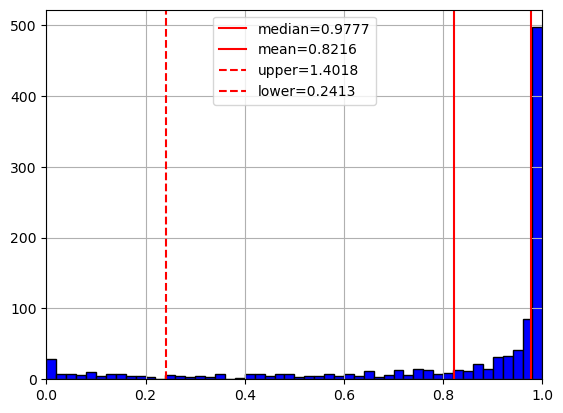

In [51]:
plot_histogram(rewards, bins=50)
plt.grid();

In [16]:
# plot_histogram(rewards[rewards >= 0.99975].float(), bins=50, xlim=(0.99975, 1.0))
# plt.grid();

In [19]:
# Save the rewards
# torch.save(rewards, "outputs/ppo_rewards_imdb_supervised_perfect_2.pt")

In [18]:
# tmp_rewards = torch.load("outputs/ppo_rewards_imdb_perfect.pt")
# tmp_rewards.dtype

## Get rewards for the base model

In [27]:
# Model
model = get_model(tokenizer_name, device, load_in_8bit=True, low_cpu_mem_usage=True)
model.eval()

memory_usage = model.pretrained_model.get_memory_footprint() / (1024 ** 3)
print(f"{memory_usage=:.2f} GB")

Loading policy model...

is_bf16_possible=False
kwargs={'load_in_8bit': True, 'low_cpu_mem_usage': True, 'torch_dtype': None}


Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded subject model with 6,738,419,713 parameters.
Model dtype: torch.float16

memory_usage=6.58 GB


In [28]:
from trl import PPOTrainer, PPOConfig

config = PPOConfig()

optimizer = None

# We then build the PPOTrainer, passing the model, the reference model, the tokenizer
ppo_trainer = PPOTrainer(
    config,
    model,
    ref_model=None,
    tokenizer=tokenizer,
    dataset=train_dataset,
    data_collator=collator,
    optimizer=optimizer,
)

In [52]:
dataloader = torch.utils.data.DataLoader(
    # train_dataset,
    # train_dataset.shuffle(seed=42).select(range(8)),
    train_dataset.shuffle(seed=2023).select(range(1024)),
    batch_size=64, collate_fn=collator,
    num_workers=12, shuffle=False,
)
print(f"Dataloader length: {len(dataloader)}")

generation_kwargs = {
    "top_k": 0,
    "top_p": 1.0,
    "do_sample": False,
    "pad_token_id": tokenizer.pad_token_id,
    "eos_token_id": 100_000, # why is this value like this?
    "pad_to_multiple_of": 8, # TODO: double-check, but this seems to work and to be faster
    "max_new_tokens": 1,
}

rewards = []
gold_outputs = []
outputs = []
for batch in tqdm(dataloader, total=len(dataloader), leave=False):
    batch_gold_outputs = batch["best_response"]
    gold_outputs.extend(batch_gold_outputs)

    question_tensors = batch["input_ids"]

    response_tensors = ppo_trainer.generate(
        question_tensors,
        return_prompt=False,
        # length_sampler=output_length_sampler, # TODO: can be none
        batch_size=8, # TODO: generations are made in batches
        **generation_kwargs,
    )
    batch["response"] = tokenizer.batch_decode(
        response_tensors, skip_special_tokens=True, spaces_between_special_tokens=False
    )
    outputs.extend(batch["response"])

    # Compute sentiment score
    texts = [q + " " + r for q, r in zip(batch["prompt"], batch["response"])]
    current_rewards = get_rewards(texts)
    rewards.append(current_rewards.cpu())


rewards = torch.cat(rewards, dim=0)
print(rewards.shape)
len(outputs), len(gold_outputs)

Loading cached shuffled indices for dataset at /admin/home-augustas/.cache/huggingface/datasets/AugustasM___parquet/AugustasM--qnli-vicuna-ppo-training-v1-e9526ea8884b4bb3/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7/cache-780fb22b96b4b982.arrow


Dataloader length: 16


  0%|          | 0/16 [00:00<?, ?it/s]

torch.Size([1024])


(1024, 1024)

In [30]:
# for output, golden_output in zip(outputs, gold_outputs):
#     print(f"{golden_output=}\n{output=}")
#     print("-" * 80)

In [53]:
rewards.min(), rewards.max()

(tensor(4.4509e-07), tensor(1.0000))

In [54]:
rewards.mean(), rewards.std()

(tensor(0.6381), tensor(0.4138))

In [55]:
rewards.mean() - rewards.std(), rewards.mean() + rewards.std()

(tensor(0.2243), tensor(1.0519))

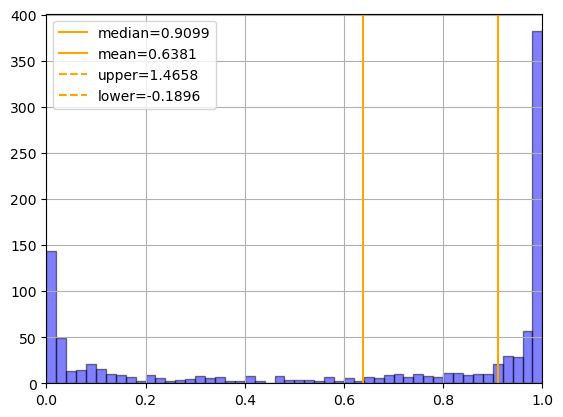

In [56]:
bins = 50
plot_histogram(rewards, bins=bins, color="blue", secondary_color="orange", alpha=0.5)
# Grid
plt.grid()

In [57]:
# Save the rewards
# torch.save(rewards, "outputs/ppo_rewards_qnli_vicuna_supervised_3B.pt")

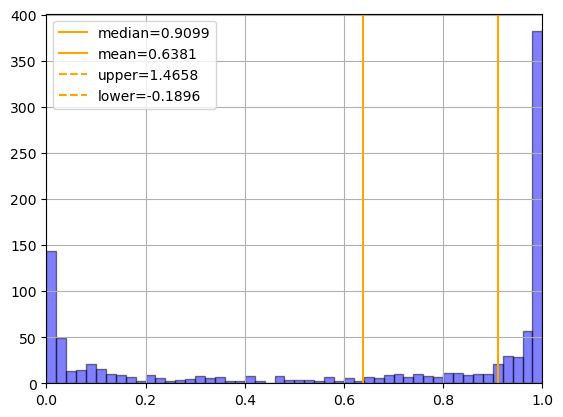

In [58]:
tmp_rewards = torch.load("outputs/ppo_rewards_qnli_vicuna_supervised_3B.pt")
bins = 50
plot_histogram(tmp_rewards, bins=bins, color="blue", secondary_color="orange", alpha=0.5)
# Grid
plt.grid()